# Downloading_and_Interpreting_IEM_Data

This comprehensive guides shows the process of finding, downloading, and interpreting data from the [Iowa Environmental Mesonet](https://mesonet.agron.iastate.edu/) (IEM) through web scraping. This will give us hourly precision on data.

This will be done by manipulating the URI and URL that produces different requests to the webserver.

## Loading all stations and station properties

This step will load the properties of all stations available to get IEM data from.
Take note of the uri manipulation.

In [1]:
import datetime
from urllib.request import urlopen
import json
from IPython.display import clear_output

# Array containing all the US States 2-Letter codes
states = """AK AL AR AZ CA CO CT DE FL GA HI IA ID IL IN KS KY LA MA MD ME
 MI MN MO MS MT NC ND NE NH NJ NM NV NY OH OK OR PA RI SC SD TN TX UT VA VT
 WA WI WV WY"""
# Array to hold the dictionary correspondent to each station
stations = []
# Looping through states
for state in states.split():
    
    clear_output(wait=True)
    print(f'Loading stations for state {state}')
    
    # Manipulating the uri to the proper network corresponding to the state
    uri = (
        "https://mesonet.agron.iastate.edu/"
        f"geojson/network/{state}_ASOS.geojson"
    )
    # Loading the data from the uri of the state
    data = urlopen(uri)
    # Appending the list of stations gathered, interpreted by json
    stations += json.load(data)["features"]
    
# This bit will clean up the dictionaries that are returned, 
# not important, but you can comment this seciton out and see how the
# original dictionaries look. Not all that pretty.
clear_output(wait=True)
print("Cleaning Up Station Information")
for station in stations:
    clear_output(wait=True)
    print(f"Cleaning Up Station Information for station {station['id']}")
    for key in station['properties'].keys():
        station[key] = station['properties'][key]
    del station['properties']
    station['lon'] = station['geometry']['coordinates'][0]
    station['lat'] = station['geometry']['coordinates'][1]
    del station['geometry']
    del station['type']
    del station['sid']
clear_output(wait=True)
print(f'{len(stations)} stations found!')


2843 stations found!


## Loading data for a particular station in a date range

This part of the code will load the data for a one specific station requested withing a date range. The data will be loaded as a dictionary and converted to a pandas dataframe.

NOTE: Not all stations will have data available for a given date range, if that's the case, choose another station.

Below is a list of the data we can gather from the stations, and what it means:

---
1. **station:** The identifier for the weather station, usually an alphanumeric code.
  
2. **valid:** The timestamp indicating when the observation was taken.

3. **lon:** Longitude of the weather station.

4. **lat:** Latitude of the weather station.

5. **tmpf:** Temperature in degrees Fahrenheit.

6. **dwpf:** Dew point temperature in degrees Fahrenheit.

7. **relh:** Relative humidity, typically given as a percentage.

8. **drct:** Wind direction in degrees, with 0° or 360° representing north.

9. **sknt:** Wind speed in knots.

10. **p01i:** Precipitation for the past 1 hour, usually in inches.

11. **alti:** Altimeter setting, which is the current pressure at sea level.

12. **mslp:** Mean Sea Level Pressure.

13. **vsby:** Visibility, typically in statute miles.

14. **gust:** Wind gust speed in knots.

15. **skyc1, skyc2, skyc3, skyc4:** Sky cover for up to four levels. This can be in terms of clear (CLR), scattered (SCT), broken (BKN), overcast (OVC), etc.

16. **skyl1, skyl2, skyl3, skyl4:** Altitude (usually in feet) at which the respective sky cover (skyc1-4) levels are observed.

17. **wxcodes:** Weather codes representing specific weather phenomena, like rain (RA), snow (SN), etc.

18. **ice_accretion_1hr:** Amount of ice accretion (ice buildup) in the past 1 hour.

19. **ice_accretion_3hr:** Amount of ice accretion in the past 3 hours.

20. **ice_accretion_6hr:** Amount of ice accretion in the past 6 hours.

21. **peak_wind_gust:** Peak wind gust observed during the period.

22. **peak_wind_drct:** Direction from which the peak wind gust came.

23. **peak_wind_time:** Time when the peak wind gust was observed.

24. **feel:** "Feels like" temperature, which takes into account factors like wind chill or heat index.

25. **metar:** METAR is a format for reporting weather information, mainly used by pilots. This column would contain the raw METAR string for the observation.

26. **snowdepth:** Depth of snow on the ground, typically measured in inches.
---

The code below shows how to get data for a single station in a date interval. I've made a few custom functions to help with the data interpretation.

Note that different stations have different time-precision


In [14]:
import numpy as np
import pandas as pd
# This variable should indicate the path from this Jupyter Notebook to the root directory of the repo.
root_path = '../'
# Adds the repo's root to the list of paths
import sys
sys.path.append(root_path)
# Utilities package
from src.backend import utils

# A custom function that turns strings into ints, floats, dates, or, if all else fails, the original string.
def my_eval(s):
    """
    Converts a string into an integer, float, or date object, depending on the string's content. 
    If the conversion is unsuccessful, returns the original string.

    This function attempts to interpret a string in the following order:
    1. Tries to convert the string to an integer.
    2. If unsuccessful, tries to convert it to a float.
    3. If still unsuccessful, tries to convert it to a date.
    4. If all conversions fail, it returns the original string.

    Parameters:
    - s (str): The string to convert.

    Returns:
    - int, float, datetime.date, or str: The converted value or the original string if all conversions fail.
    """
    try:
        # Try to convert the string to a number (int or float)
        return int(s)
    except ValueError:
        try:
            return float(s)
        except ValueError:
            try:
                # Try to convert the string to a datetime date
                return datetime.datetime.strptime(s, '%Y-%m-%d').date()
            except ValueError:
                # If all conversions fail, return the original string
                return s
            
# Function that will interpret the utf-8 text data recovered and turn it into a dataframe
def text_to_dataframe(data):
    """
    Converts a text block of data into a Pandas DataFrame.

    The function processes a long string of data, where each line represents either a comment, 
    a header (with column names), or a row of data. Lines beginning with '#' are comments and 
    are ignored, as are empty lines. The first line of non-commented text is treated as the header, 
    providing the column names for the DataFrame. Subsequent lines of data are split by commas 
    and added to the respective columns.

    Each entry in the data is processed by the 'my_eval' function to attempt conversion into 
    int, float, or date types, falling back to the original string if necessary.

    Parameters:
    - data (str): The block of text data to convert.

    Returns:
    - DataFrame: A Pandas DataFrame representing the structured data.
    """

    # Dictionary that will become a dataframe
    data_values = {}
    # Looping thorugh lines of data
    for line in data.split('\n'):
        # Ignoring empty lines or commented-out lines
        if not line.startswith('#') and len(line) > 0:
            # The first non-commented line contains the data columns.
            # If there's nothing in the dictionary, it means that we're there, redefine the dictionary
            if len(data_values) == 0:
                # Start a dictionary where the keys are the columns, and entries are empty arrays (which we'll populate)
                data_values = {col:[] for col in line.split(',')}
            # If we're not in the columns line, we're in a line that contains data
            else:
                # Split data and append it to each entry of dictionary
                line_data = line.split(',')
                for i, col in enumerate(data_values.keys()):
                    data_values[col] += [my_eval(line_data[i])]
    return pd.DataFrame(data_values)

# Function to filter stations to ones that have any data in between startts and endts
def filter_stations(stations, startts, endts):
    """
    Filter the list of station dictionaries. Include a station if its operation 
    dates overlap with the provided startts and endts, even partially.

    Parameters:
    - stations (list of dicts): The list of station dictionaries.
    - startts (datetime): The start datetime.
    - endts (datetime): The end datetime.

    Returns:
    - list of dicts: The filtered list of stations.
    """
    filtered_stations = []

    for station in stations:
        # Parse the station's operation start and end dates.
        # It's important to handle cases where these dates are None or empty strings.
        archive_begin_str = station.get('archive_begin', '')
        archive_end_str = station.get('archive_end', '')

        try:
            archive_begin = datetime.datetime.strptime(archive_begin_str, '%Y-%m-%d') if archive_begin_str else None
        except ValueError:
            archive_begin = None

        try:
            # If archive_end is None or an empty string, we assume the station is still operational
            archive_end = datetime.datetime.strptime(archive_end_str, '%Y-%m-%d') if archive_end_str else datetime.datetime.max
        except ValueError:
            archive_end = None

        # Check if the station's operation dates overlap with the query dates.
        # The station is considered valid if its operation dates overlap even partially with the query dates.
        if archive_begin is not None and archive_end is not None:
            if (startts <= archive_end and endts >= archive_begin):
                filtered_stations.append(station)

    return filtered_stations

# Start and end dates for analysis
startts = datetime.datetime(2023, 1, 1)
endts = datetime.datetime(2023, 1, 2)
# Filtering stations to ones that have data in between startts and endtts
stations = filter_stations(stations, startts, endts)
# Base URL to manipulate
service = "http://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?data=all&tz=Etc/UTC&format=comma&latlon=yes&"
# Adding dates to URL in proper format
service += startts.strftime("year1=%Y&month1=%m&day1=%d&")
service += endts.strftime("year2=%Y&month2=%m&day2=%d&")
# Specifying the station to get data from
station = stations[0]
# These are the data columns that we care about, we'll ignore the rest
columns_of_interest = ['station', 'valid', 'lon', 'lat', 'tmpf',
                    'relh', 'drct', 'sknt', 'p01i', 'skyc1', 'skyc2',
                    'skyc3', 'skyc4', 'skyl1', 'skyl2', 'skyl3', 'skyl4',
                    'wxcodes', 'ice_accretion_1hr', 'metar']
# Building proper uri for the request
uri = f"{service}&station={station['id']}"

clear_output(wait=True)
print(f"Requesting data for station {station['id']} on base-url: {service}")
# Loading raw data for a single station
data = urlopen(uri, timeout=300).read().decode("utf-8")
# Interpreting data to a dataframe
data = text_to_dataframe(data)[columns_of_interest]

# This Section will slightly tweak some aspects of the data to make them nicer and more human-readable

# Interprets the 'valid' entry as a datetime object
data['valid'] = pd.to_datetime(data['valid'])
# Calculates the equivalent timestamp to each date
data['timestamp'] = data['valid'].apply(utils.to_unix_timestamp)
# Whenever there's missing data, it's filled with an 'M', this code will replace that with NaNs
data = data.replace('M', np.nan)
# This code will create the column `wspd`, which is the measured wind speed in meters per second, instead of knots.
data['wspd'] = data['sknt']*0.514444
# Creates columns of the North and East decomposition of the wind vector
data['wind_E'] = np.sin(data['drct']/180*np.pi)*data['wspd']
data['wind_N'] = np.cos(data['drct']/180*np.pi)*data['wspd']
# Creating a dataframe for the stations found so we can assign an elevation to the data according to the station id.
stations_df = pd.DataFrame(stations)
# Assigning 'elevation' to each entry based on the station id
data = pd.merge(data, stations_df[['id', 'elevation']], left_on='station', right_on='id', how='left')
# Deleting 'id' column that is created as a side-product of the process above
data.drop('id', axis='columns', inplace=True)

# sorting data by date
data.sort_values(by='valid', ignore_index=True, inplace=True)
data

Requesting data for station PADK on base-url: http://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?data=all&tz=Etc/UTC&format=comma&latlon=yes&year1=2023&month1=01&day1=01&year2=2023&month2=01&day2=02&


'PADK 010043Z AUTO 36009KT BKN009 OVC021 02/01 A2891 RMK AO2 CIG 007V014 P0001 PWINO FZRANO $'

## Loading data for multiple stations

This section is little more than a for loop, going through the stations and loading the data appropriately into one large dataframe.

This will take a while...

In [3]:
# Stating the dataframe holding the weather data as empty
all_stations_data = pd.DataFrame({col:[] for col in columns_of_interest})
# Looping through all the stations
for i, station in enumerate(stations):
    # Building proper uri for the request
    uri = f"{service}&station={station['id']}"
    clear_output(wait=True)
    print(f"Requesting data for station {station['id']} on base-url: {service} | {i} / {len(stations)}")
    # Loading raw data for a single station
    data = urlopen(uri, timeout=300).read().decode("utf-8")
    # Interpreting data to a dataframe
    all_stations_data = pd.concat([all_stations_data, text_to_dataframe(data)[columns_of_interest]])

clear_output(wait=True)
print(f"Performing small tweaks to the data")
# Same as before, let's tweak the data a bit
# Interprets the 'valid' entry as a datetime object
all_stations_data['valid'] = pd.to_datetime(all_stations_data['valid'])
# Calculates the equivalent timestamp to each date
all_stations_data['timestamp'] = all_stations_data['valid'].apply(utils.to_unix_timestamp)
# Whenever there's missing data, it's filled with an 'M', this code will replace that with NaNs
all_stations_data = all_stations_data.replace('M', np.nan)
# This code will create the column `wspd`, which is the measured wind speed in meters per second, instead of knots.
all_stations_data['wspd'] = all_stations_data['sknt']*0.514444
# Creates columns of the North and East decomposition of the wind vector
all_stations_data['wind_E'] = np.sin(all_stations_data['drct']/180*np.pi)*all_stations_data['wspd']
all_stations_data['wind_N'] = np.cos(all_stations_data['drct']/180*np.pi)*all_stations_data['wspd']
# Creates a column of temepratures in Celcius
all_stations_data['tmpc'] = (all_stations_data['tmpf']-32)*5/9

# Assigning 'elevation' to each entry based on the station id
all_stations_data = pd.merge(all_stations_data, stations_df[['id', 'elevation']], left_on='station', right_on='id', how='left')
# Deleting 'id' column that is created as a side-product of the process above
all_stations_data.drop('id', axis='columns', inplace=True)

# sorting data by date
all_stations_data.sort_values(by='valid', ignore_index=True, inplace=True)
all_stations_data.index = range(len(all_stations_data))
all_stations_data

Performing small tweaks to the data


,station,valid,lon,lat,tmpf,relh,drct,sknt,p01i,skyc1,...,skyl3,skyl4,wxcodes,ice_accretion_1hr,timestamp,wspd,wind_E,wind_N,tmpc,elevation
0,PADK,2023-01-01 00:00:00,-176.6460,51.8780,NaN,NaN,360.0,11.0,NaN,SCT,...,3500.0,NaN,NaN,NaN,1672531200,5.658884,-1.386027e-15,5.658884e+00,NaN,4.000000
1,ZZV,2023-01-01 00:00:00,-81.8921,39.9445,NaN,NaN,270.0,7.0,NaN,BKN,...,3900.0,NaN,NaN,NaN,1672531200,3.601108,-3.601108e+00,-6.615128e-16,NaN,268.000000
2,TDR,2023-01-01 00:00:00,-85.5765,30.0700,66.2,93.92,150.0,3.0,0.0,SCT,...,NaN,NaN,BR,NaN,1672531200,1.543332,7.716660e-01,-1.336565e+00,19.000000,3.830895
3,YNG,2023-01-01 00:00:00,-80.6739,41.2544,NaN,NaN,300.0,7.0,NaN,OVC,...,NaN,NaN,NaN,NaN,1672531200,3.601108,-3.118651e+00,1.800554e+00,NaN,360.000000
4,PNS,2023-01-01 00:00:00,-87.1869,30.4781,NaN,NaN,NaN,NaN,NaN,OVC,...,NaN,NaN,NaN,NaN,1672531200,NaN,NaN,NaN,NaN,37.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415940,PUW,2023-01-01 23:59:00,-117.1096,46.7439,30.9,96.41,330.0,4.0,0.0,OVC,...,NaN,NaN,BR,NaN,1672617540,2.057776,-1.028888e+00,1.782086e+00,-0.611111,778.000000
415941,HUT,2023-01-01 23:59:00,-97.8606,38.0655,49.0,74.05,20.0,11.0,0.0,CLR,...,NaN,NaN,NaN,NaN,1672617540,5.658884,1.935452e+00,5.317612e+00,9.444444,470.000000
415942,FME,2023-01-01 23:59:00,-76.7594,39.0854,41.0,93.24,0.0,0.0,0.0,CLR,...,NaN,NaN,NaN,NaN,1672617540,0.000000,0.000000e+00,0.000000e+00,5.000000,46.000000
415943,BJC,2023-01-01 23:59:00,-105.1172,39.9088,30.2,86.28,350.0,9.0,0.0,BKN,...,NaN,NaN,NaN,NaN,1672617540,4.629996,-8.039904e-01,4.559656e+00,-1.000000,1724.000000


## Plotting and Processing Weather Data

This section will cover some of the plotting and interpolation done with the weather data.

### Plotting Weather Stations on a Map

In this section we'll layout the usage of the `cartopy` cartography module, and how to plot quantities and things on maps according to longitudes and latitudes.

As an illustrative example, we'll plot the location of all the weather stations we'll be using for data.

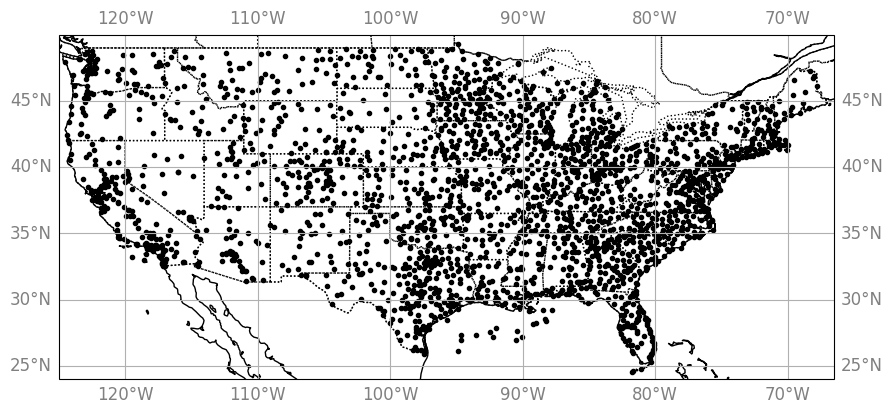

In [4]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# Makes sure matplotlib can display the plots properly
%matplotlib inline

# These coordinates almost 100% encompass the US (except for Alaska and Hawaii), let's limit ourselves to that
west_lon = -125
east_lon = -66.5
north_lat = 50
south_lat = 24

# Masking away stations and datapoints that are not within the ranges for lat and lon
mask_lat = (stations_df['lat'] >= south_lat) & (stations_df['lat'] <= north_lat)
mask_lon = (stations_df['lon'] >= west_lon) & (stations_df['lon'] <= east_lon)
stations_df = stations_df[mask_lat & mask_lon]
stations_df.index = range(len(stations_df))

mask_lat = (all_stations_data['lat'] >= south_lat) & (all_stations_data['lat'] <= north_lat)
mask_lon = (all_stations_data['lon'] >= west_lon) & (all_stations_data['lon'] <= east_lon)
all_stations_data = all_stations_data[mask_lat & mask_lon]
all_stations_data.index = range(len(all_stations_data))

# Initializing figure and axis objects (separately)
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()},
                       figsize=[10, 10])
# Adding boarders, coastlines, and states
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=':')

ax.scatter(stations_df['lon'], stations_df['lat'], color = 'k', marker = '.')
ax.set_extent([west_lon, east_lon, south_lat, north_lat], crs=ccrs.PlateCarree())  # crs indicates the coordinate reference system

gridlines = ax.gridlines(draw_labels=True)
gridlines.xlabel_style = {'size': 12, 'color': 'gray'}
gridlines.ylabel_style = {'size': 12, 'color': 'gray'}



### Interpolating Data

In order to interpolate any quantity of interest, we'll be using Gaussian Interpolation. That is, the temperature at point $p_o$ is the weighted average of the temperature at all other points $p_i$, where the weight is the value of a gaussian function peaked at $p_i$ with peak-height $Q_i$ (quantity measured at point i) with width $\sigma_i$. That is:

$$Q(p_o) = \frac{\sum_i w_i Q(p_i)}{\sum_iw_i}$$
where
$$w_i = exp\left(-\frac{d\left(p_o,p_i\right)^2}{2\sigma_i^2}\right)$$
$Q$ is the quantity of interest

and $d$ is the distance function between points $p_o$ and $p_i$. Since we have information about latitude and longitude, the distance function between any two points can be found using the Haversine formula:
$$d(p_1,p_2) = \left|2R\ \text{atan2}\left(\sqrt{a},\sqrt{1-a}\right)\right|$$
Where
$$a = \sin^2\left(\frac{p_{2,\text{lat}}-p_{1,\text{lat}}}{2}\right) + \cos\left(p_{1,\text{lat}}\right)\cos\left(p_{2,\text{lat}}\right)\sin^2\left(\frac{p_{2,\text{lon}} - p_{1,\text{lon}}}{2}\right)$$
and $R$ is the radius of earth in meters (~$6.371\times10^6\ m$)

For this application, $\sigma$ represents how much weight the station $i$ will have relative to others.
 - High $\sigma$ would give more influence to far away stations
 - Low $\sigma$ would give more influence to close by stations
A good value for sigma should relate to the relative density of weather stations in certain areas
 - Areas with few weather stations should have a larger value of $\sigma$
 - Areas with a lot of weather stations should have a smaller value of $\sigma$

The value we'll use for $\sigma_i$ is the average distance to the 5 closest stations to $i$ (other than itself)

The code below takes care of computing the $\sigma$ associated to each station

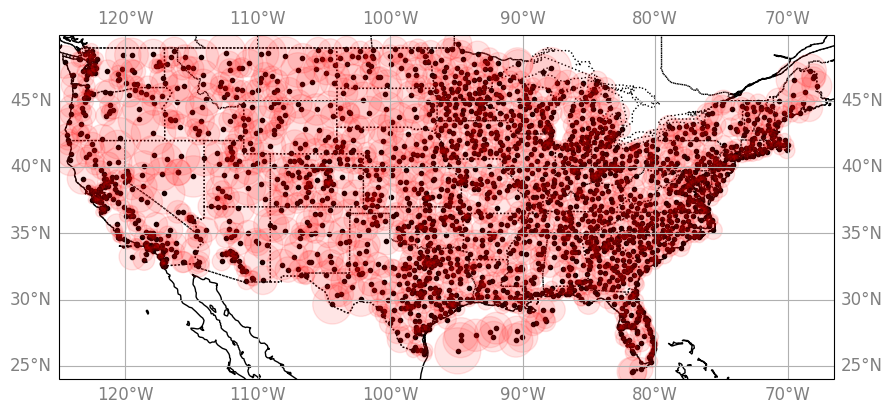

In [5]:
from matplotlib.patches import Circle

def meters_to_degrees(meters, latitude):
    """
    Convert distance from meters to degrees at a specific latitude.

    Args:
    meters (float): Distance in meters.
    latitude (float): Latitude at which the conversion is happening.

    Returns:
    float: Distance in degrees.
    """
    # Earth's radius in meters
    EARTH_RADIUS = 6.371e6
    
    # Conversion from degrees to radians
    latitude_radians = latitude/180*np.pi
    
    # Number of meters in a radian
    meters_per_radian = EARTH_RADIUS

    # Calculate the number of meters per degree of latitude and longitude
    meters_per_degree_lat = (np.pi / 180) * EARTH_RADIUS
    meters_per_degree_lon = (np.pi / 180) * EARTH_RADIUS * np.cos(latitude_radians)

    # Calculate the distance in degrees
    degrees_lat = meters / meters_per_degree_lat
    degrees_lon = meters / meters_per_degree_lon

    # We return the mean value considering changes in latitude may affect the circle shape
    return (degrees_lat + degrees_lon) / 2


def add_station_circle(ax, center_lon, center_lat, radius, edgecolor, facecolor, alpha):
    """
    Adds a circle on the map.

    Args:
    ax: The axes to draw onto.
    center_lon (float): Longitude of circle center.
    center_lat (float): Latitude of circle center.
    radius (float): Radius of circle (in the same units as the center coordinates).
    edgecolor (str): The color of the circle edge.
    facecolor (str): The color of the circle area.
    alpha (float): The alpha (transparency) of the circle.
    """
    circle = Circle(xy=(center_lon, center_lat), radius=radius, transform=ccrs.PlateCarree(),
                    edgecolor=edgecolor, facecolor=facecolor, alpha=alpha, zorder=2)
    ax.add_patch(circle)

def haversine_distance(lat1, lon1, lat2, lon2, R=6.371e6):
    """
    Calculate the Haversine distance between two points on the earth specified by longitude and latitude.

    The Haversine formula calculates the shortest distance over the earth’s surface, giving an 'as-the-crow-flies'
    distance between the points (ignoring any hills, valleys, or other potential obstacles). This function uses
    the radius of the earth specified by `R` but defaults to the mean earth radius if `R` is not provided.

    Args:
    lat1 (float): Latitude of the first point in degrees.
    lon1 (float): Longitude of the first point in degrees.
    lat2 (float): Latitude of the second point in degrees.
    lon2 (float): Longitude of the second point in degrees.
    R (float, optional): Earth radius in meters. Default is the mean earth radius (6.371e6 meters).

    Returns:
    float:  Distance between the points in meters.
    """
    # Convert latitude and longitude from degrees to radians
    lat1_rad = lat1/180*np.pi
    lon1_rad = lon1/180*np.pi
    lat2_rad = lat2/180*np.pi
    lon2_rad = lon2/180*np.pi

    # Difference in coordinates
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2

    return abs(R * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))

n_avg_sigma = 5
# Initiating an array full of zeros that will hold the sigmas for each station
sigmas = np.zeros(len(stations_df))
for i, row in stations_df.iterrows():
    # For every station, compute the distance to all other locations
    distances = haversine_distance(row['lat'], row['lon'], stations_df['lat'], stations_df['lon'])
    # Sort them from smallest to largers
    distances = sorted(distances)
    # Take the average of the closest 5 (not including itself)
    sigmas[i] = np.mean(distances[1:n_avg_sigma+1])
# Assigning sigmas to all stations
stations_df['sigma'] = sigmas
# Assigning sigma measure to each measurement
all_stations_data = pd.merge(all_stations_data, stations_df[['id', 'sigma']], left_on='station', right_on='id', how='left')
# Deleting 'id' column that is created as a side-product of the process above
all_stations_data.drop('id', axis='columns', inplace=True)

# We can visualize this data now on the map, where each circle represents the widths of
# the corresponding gaussian, in other words, the "area of influence"

# Initializing figure and axis objects (separately)
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()},
                       figsize=[10, 10])
# Adding boarders, coastlines, and states
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=':')

ax.scatter(stations_df['lon'], stations_df['lat'], color = 'k', marker = '.')
for idx, row in stations_df.iterrows():
    # Convert the 'sigma' value from meters to degrees
    sigma_in_degrees = meters_to_degrees(row['sigma'], row['lat'])

    add_station_circle(ax, row['lon'], row['lat'], sigma_in_degrees,
                       edgecolor='red', facecolor='red', alpha=0.1)

ax.set_extent([west_lon, east_lon, south_lat, north_lat], crs=ccrs.PlateCarree())  # crs indicates the coordinate reference system

gridlines = ax.gridlines(draw_labels=True)
gridlines.xlabel_style = {'size': 12, 'color': 'gray'}
gridlines.ylabel_style = {'size': 12, 'color': 'gray'}

### Interpolating Temperature data

As we can see from the data, all the measures were taken at a given latitude, longitude, and altitude (elevation).
That's fine, but that means that the temperature taken at different elevations can't really be compared together, especially when trying to interpolate data for a third lat, lon, elev point. So what we'll do here is use a temperature gradient model to transform the data.

We'll use a simple _Environmental Lapse Rate (ELR)_ or _Adiabatic Lapse Rate (ALR)_ model for temperature:

$$T(h) = T(h_o) + L_R\left(h - h_o\right)$$

Where:
 - $T(h_o)$ is the tempearature where it was measured (In Degrees Celcius)
 - $h_o$ is the elevation of where the temperature was measured (In Meters)
 - $L_R$ is the atmospheric _Lapse Rate_, that is, how many degrees the temeperature changes per meter of height (In Degrees Celcius/Meter). A stardard value used for it is $-6.5\times10^{-3}\ {}^oC/m$
 - $T(h)$ is the estimated temperature at altutude $h$.
 
So, the first thing we'll do is calculate the estimated temperature at sea level $h = 0$

In [6]:
def estimate_temperature(base_temp, base_altitude, target_altitude, lapse_rate=-6.5e-3, lapse_rate_err=0):
    """
    Estimate the temperature at a target altitude.
    Args:
    base_temp (float): The known temperature at the base altitude (in degrees Celsius).
    base_altitude (float): The base altitude in meters.
    target_altitude (float): The target altitude in meters for which to estimate the temperature.
    lapse_rate (optional) (float): The atmospheric lapse rate being used.
    
    Returns:
    float: The estimated temperature at the target altitude.
    """
    # Calculate the estimated temperature at the target altitude
    estimated_temp = base_temp + lapse_rate*(target_altitude - base_altitude)
    return estimated_temp

all_stations_data['tslv'] = estimate_temperature(all_stations_data['tmpc'], all_stations_data['elevation'], 0)


Now we have everything we need to interpolate the temperature at any altitude for any point in space and time. Let's rememeber that data is also taken at different times, and we don't want the data from 6 hours ago to influence our data now, so let's make it so we only care about data that's within **1 hr** of the point we want to predict data for.
ALSO, within that 1 hour, the same station will have many measures of temperature, we want to make sure to only keep 1 measure per station, so we'll need to average them all.

The code below shows the example code we can use for a single point in space and time

In [15]:
def gaussian_interpolation(target, data, quantity):
    """
    Perform a Gaussian-weighted interpolation for a specified quantity based on geographic proximity.

    This function computes distances between a target location and a set of locations in the data,
    then applies a Gaussian weighting based on these distances and the 'sigma' values of the stations.
    The result is a weighted average of the specified quantity, considering the influence of each
    station's data based on its spatial relationship to the target point.

    Parameters:
    target (dict): A dictionary representing the target point, containing 'lat' and 'lon' keys with
                   geographical coordinates.
    data (pd.DataFrame): A DataFrame containing station data, each row representing a station. It must
                         include 'lat', 'lon', and 'sigma' columns, representing the geographical
                         coordinates of the station and the standard deviation of the Gaussian distribution
                         used for weighting, respectively. The DataFrame also contains a column corresponding
                         to the 'quantity' parameter that holds the values to be interpolated.
    quantity (str): The name of the column in 'data' that represents the quantity to be interpolated. This
                    column's values are numerically interpolated.

    Returns:
    float: The Gaussian-weighted interpolated value of the specified quantity at the target location.
    """

    distances = haversine_distance(target['lat'], target['lon'], data['lat'], data['lon'])
    # If the target is too far way from any station (5 sigma), the measure is not reliable.
    if min(distances) > 3*np.mean(data['sigma']):
        return np.nan
    weights = np.exp(-distances**2/(2*data['sigma']**2/10))
    weights = weights/np.sum(weights)
    avg = np.sum(weights*data[quantity])
    return avg


target = {'lon': -99.29,
          'lat': 40.30,
          'elevation': 373.22,
          'timestamp': 1672574062.84}

quantity = 'tslv'

relevant_data = all_stations_data[['station', 'lat', 'lon', 'elevation', 'timestamp', quantity, 'sigma']].copy()
relevant_data = all_stations_data[abs(all_stations_data['timestamp'] - target['timestamp']) <= 3600/2]
relevant_data = relevant_data.dropna(subset=[quantity])
relevant_data = relevant_data.groupby('station').agg({
    'lon': 'mean',
    'lat': 'mean',
    'elevation': 'mean',
    'timestamp': 'mean',
    quantity: 'mean',
    'sigma': 'mean'
})
interpolated_t = gaussian_interpolation(target, relevant_data, quantity)
interpolated_t = estimate_temperature(interpolated_t, 0, target['elevation'])
print(f'The interpolated target temperature is {interpolated_t} Degrees Celcius')


The interpolated target temperature is 1.3432455596039703 


Now let's interpolate it for a grid of points all through the US.

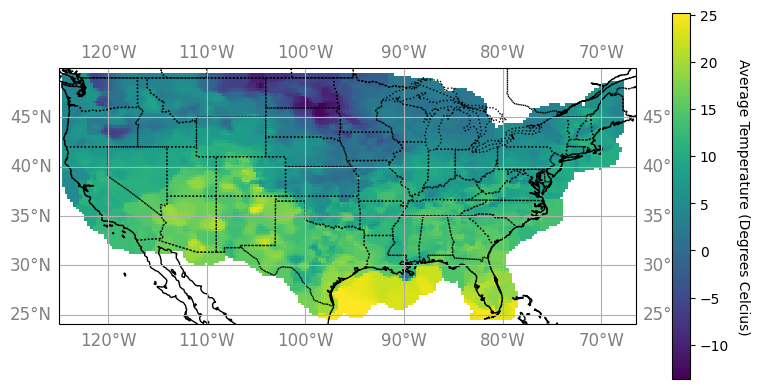

In [8]:
# timestamp of when we'd like the data to be interpolated for
target_timestamp = 1672574062.84
# elevation of the inteprolated data
target_elevation = 0
# quantity to be interpolated
quantity = 'tslv'
# Treating data for only the relevant data
relevant_data = all_stations_data[['station', 'lat', 'lon', 'elevation', 'timestamp', quantity, 'sigma']].copy()
relevant_data = all_stations_data[abs(all_stations_data['timestamp'] - target['timestamp']) <= 3600/2]
relevant_data = relevant_data.dropna(subset=[quantity])
relevant_data = relevant_data.groupby('station').agg({
    'lon': 'mean',
    'lat': 'mean',
    'elevation': 'mean',
    'timestamp': 'mean',
    quantity: 'mean',
    'sigma': 'mean'
})

# latitude grid to cover
precision_lon = 200
precision_lat = 100
lons = np.linspace(stations_df['lon'].min(), stations_df['lon'].max(), num=precision_lon)
lats = np.linspace(stations_df['lat'].min(), stations_df['lat'].max(), num=precision_lat)

# Making grid of points
LONS, LATS = np.meshgrid(lons, lats)
lons_grid = np.ravel(LONS)
lats_grid = np.ravel(LATS)
interpolated_temperatures = np.array([gaussian_interpolation({'lon':lon, 'lat':lat}, relevant_data, quantity)
                                  for lon, lat in zip(lons_grid, lats_grid)])

TEMPS = interpolated_temperatures.reshape(LONS.shape)

TEMPS = estimate_temperature(TEMPS, 0, target_elevation)

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()},
                       figsize=[8, 4])

# Adding boarders, coastlines, and states
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=':')

# Plotting temperature map
cax = ax.pcolormesh(LONS, LATS, TEMPS, shading='auto')

# Making a colorbar
cbar = fig.colorbar(cax, ax=ax, orientation='vertical')

# Naming the colorbar
cbar.set_label('Average Temperature (Degrees Celcius)', rotation=270, labelpad=15)

ax.set_extent([west_lon, east_lon, south_lat, north_lat], crs=ccrs.PlateCarree())  # crs indicates the coordinate reference system

gridlines = ax.gridlines(draw_labels=True)
gridlines.xlabel_style = {'size': 12, 'color': 'gray'}
gridlines.ylabel_style = {'size': 12, 'color': 'gray'}

fig.tight_layout()

### Interpolating Wind Vector Data

For the wind, we'll be doing the same as we did with tempearture, but separately for East and North components of the wind vector we computed above.

The model used for wind speed is a simple gradient model:
$$S(h) = S(h_o) + W_G\left(h - h_o\right)$$

Note, there are better models [here](https://en.wikipedia.org/wiki/Wind_gradient#Wind_turbines:~:text=Wind%20turbines%5B,as%3A%5B27%5D), but some break down at negative elevations

Where
 - $S(h_o)$ is the wind speed where it was measured (In Meters/Second)
 - $h_o$ is the elevation of where the wind speed was measured (In Meters)
 - $W_G$ is the _Wind Gradient_, that is, how many m/s the wind speed changes per meter of height (In Meters per Second/Meter). A stardard value used for it is $0.02\ m/s/m$
 - $S(h)$ is the estimated wind speed at altitude $h$.

In [9]:
def estimate_wind_speed(base_wind_speed, base_altitude, target_altitude, gradient=0.02):
    """
    Estimate the wind speed at a target altitude based on a simple wind gradient.
    
    Args:
    base_wind_speed (float): The known wind speed at the base altitude (in meters/second).
    base_altitude (float): The base altitude in meters.
    target_altitude (float): The target altitude in meters for which to estimate the wind speed.
    gradient (float): The rate at which wind speed increases with altitude (in (m/s)/m).

    Returns:
    float: The estimated wind speed at the target altitude.
    """

    # Calculate the estimated wind speed at the target altitude
    estimated_wind_speed = base_wind_speed + gradient * (target_altitude - base_altitude)

    return estimated_wind_speed

all_stations_data['wslv_E'] = estimate_temperature(all_stations_data['wind_E'], all_stations_data['elevation'], 0)
all_stations_data['wslv_N'] = estimate_temperature(all_stations_data['wind_N'], all_stations_data['elevation'], 0)

The code below shows the example code we can use for a single point in space and time

In [10]:
target = {'lon': -99.29,
          'lat': 40.30,
          'elevation': 373.22,
          'timestamp': 1672574062.84}

quantity_a = 'wslv_E'
quantity_b = 'wslv_N'

relevant_data = all_stations_data[['station', 'lat', 'lon', 'elevation', 'timestamp', quantity_a, quantity_b, 'sigma']].copy()
relevant_data = all_stations_data[abs(all_stations_data['timestamp'] - target['timestamp']) <= 3600/2]
relevant_data = relevant_data.dropna(subset=[quantity_a, quantity_b])
relevant_data = relevant_data.groupby('station').agg({
    'lon': 'mean',
    'lat': 'mean',
    'elevation': 'mean',
    'timestamp': 'mean',
    quantity_a: 'mean',
    quantity_b: 'mean',
    'sigma': 'mean'
})

interpolated_wind_E = gaussian_interpolation(target, relevant_data, quantity_a)
interpolated_wind_N = gaussian_interpolation(target, relevant_data, quantity_b)
interpolated_wind_E = estimate_wind_speed(interpolated_wind_E, 0, target['elevation'])
interpolated_wind_N = estimate_wind_speed(interpolated_wind_N, 0, target['elevation'])

print(f'The interpolated target wind vector is {(interpolated_wind_E, interpolated_wind_N)}')

The interpolated target wind vector is (12.79768515868249, 14.44332814565396)


Now let's interpolate it for a grid of points all through the US.

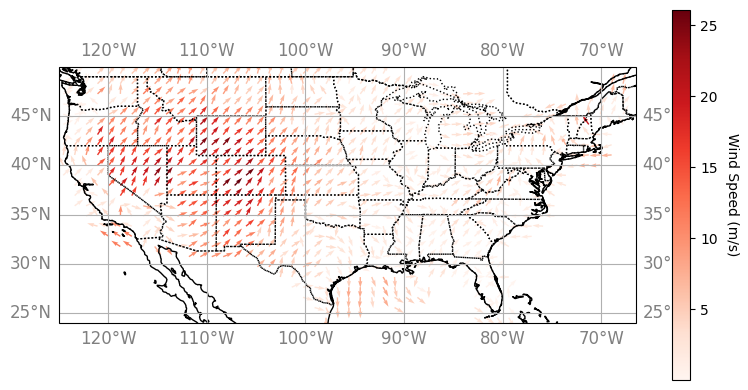

In [11]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# timestamp of when we'd like the data to be interpolated for
target_timestamp = 1672574062.84
# elevation of the inteprolated data
target_elevation = 0
# quantities to be interpolated
quantity_a = 'wslv_E'
quantity_b = 'wslv_N'
# Treating data for only the relevant data
relevant_data = all_stations_data[['station', 'lat', 'lon', 'elevation', 'timestamp', quantity_a, quantity_b, 'sigma']].copy()
relevant_data = all_stations_data[abs(all_stations_data['timestamp'] - target['timestamp']) <= 3600/2]
relevant_data = relevant_data.dropna(subset=[quantity_a, quantity_b])
relevant_data = relevant_data.groupby('station').agg({
    'lon': 'mean',
    'lat': 'mean',
    'elevation': 'mean',
    'timestamp': 'mean',
    quantity_a: 'mean',
    quantity_b: 'mean',
    'sigma': 'mean'
})

# latitude grid to cover
precision_lon = 50
precision_lat = 25
lons = np.linspace(stations_df['lon'].min(), stations_df['lon'].max(), num=precision_lon)
lats = np.linspace(stations_df['lat'].min(), stations_df['lat'].max(), num=precision_lat)

# Making grid of points
LONS, LATS = np.meshgrid(lons, lats)
lons_grid = np.ravel(LONS)
lats_grid = np.ravel(LATS)
interpolated_winds_E = np.array([gaussian_interpolation({'lon':lon, 'lat':lat}, relevant_data, quantity_a)
                                  for lon, lat in zip(lons_grid, lats_grid)])
interpolated_winds_N = np.array([gaussian_interpolation({'lon':lon, 'lat':lat}, relevant_data, quantity_b)
                                  for lon, lat in zip(lons_grid, lats_grid)])


WIND_E = interpolated_winds_E.reshape(LONS.shape)
WIND_N = interpolated_winds_N.reshape(LONS.shape)

WIND_E = estimate_wind_speed(WIND_E, 0, target_elevation)
WIND_N = estimate_wind_speed(WIND_N, 0, target_elevation)

wind_e = np.ravel(WIND_E)
wind_n = np.ravel(WIND_N)

# Nans break the quiver plotting, so let's remove them
nan_mask = ~(np.isnan(wind_e) | np.isnan(wind_n))
wind_e = wind_e[nan_mask]
wind_n = wind_n[nan_mask]
lons_grid = lons_grid[nan_mask]
lats_grid = lats_grid[nan_mask]

mags = np.sqrt(wind_e**2 + wind_n**2)
mags_norm = (mags - np.min(mags))/(np.max(mags) - np.min(mags))

colors = plt.cm.Reds(mags_norm)

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()},
                       figsize=[8, 4])

# Adding boarders, coastlines, and states
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=':')

ax.quiver(lons_grid, lats_grid, wind_e/mags, wind_n/mags, color = colors)

norm = Normalize(vmin=np.min(mags), vmax=np.max(mags))
sm = ScalarMappable(cmap="Reds", norm=norm)  # use the same colormap ("Reds") as in your plot
sm.set_array([])  # this line may be necessary depending on your matplotlib version

# Adding the colorbar based on the ScalarMappable with the right normalization
cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Wind Speed (m/s)', rotation=270, labelpad=15)  # set the label of the colorbar

ax.set_extent([west_lon, east_lon, south_lat, north_lat], crs=ccrs.PlateCarree())  # crs indicates the coordinate reference system

gridlines = ax.gridlines(draw_labels=True)
gridlines.xlabel_style = {'size': 12, 'color': 'gray'}
gridlines.ylabel_style = {'size': 12, 'color': 'gray'}

fig.tight_layout()

In [32]:
all_stations_data.sort_values(by=['station', 'timestamp'], inplace=True)

def interpolate_selected_columns(group, columns_to_interpolate):
    for column in columns_to_interpolate:
        if column in group:
            # Interpolate the specified column
            group[column] = group[column].interpolate(method='linear', limit_direction='both')
    return group

columns_to_interpolate = ['lon', 'lat', 'tmpf', 'relh', 'p01i',
                          'ice_accretion_1hr', 'timestamp', 'wspd', 'wind_E',
                          'wind_N']
# Group by 'station' and apply the interpolation function within each group
data_interpolated = data.groupby('station', group_keys=False).apply(lambda g: interpolate_selected_columns(g, columns_to_interpolate))


In [35]:
np.unique(all_stations_data['station'].apply(str)), np.unique(data_interpolated['station'])

(array(['0.0', '04V', '04W', ..., 'ZPH', 'ZZV', 'inf'], dtype=object),
 array(['PADK'], dtype=object))

In [17]:
all_stations_data.columns

Index(['station', 'valid', 'lon', 'lat', 'tmpf', 'relh', 'drct', 'sknt',
       'p01i', 'skyc1', 'skyc2', 'skyc3', 'skyc4', 'skyl1', 'skyl2', 'skyl3',
       'skyl4', 'wxcodes', 'ice_accretion_1hr', 'timestamp', 'wspd', 'wind_E',
       'wind_N', 'tmpc', 'elevation', 'sigma', 'tslv', 'wslv_E', 'wslv_N'],
      dtype='object')

In [34]:
np.unique(all_stations_data['station'].apply(str))

array(['0.0', '04V', '04W', ..., 'ZPH', 'ZZV', 'inf'], dtype=object)